In [1]:
%load_ext autoreload
%autoreload 2

import glob
import logging
import os

import numpy as np
import pandas as pd
import scipy.io as sio
import torch
import matplotlib.pyplot as plt

from adaptive_bss_semg import *

# Log file
LOG_FILE = "logs.txt"
logging.basicConfig(
    filename=LOG_FILE, encoding="utf-8", level=logging.INFO, filemode="w", force=True
)

if torch.cuda.is_available:
    device = torch.device("cuda:0")
    logging.info("Using CUDA version")
else:
    device = torch.device("cpu")
    logging.info("Using CPU version")

DATA_DIR = "data"
SUBJECT = 1
FS = 4000
SEED = 42

In [2]:
def load_data(root: str, subject_id: int, task: str) -> np.ndarray:
    """Load data from the ESB dataset.

    Parameters
    ----------
    root : str
        Path to dataset root folder.
    subject_id : int
        Subject id (1, 2 or 3).
    task : str
        Task type ("isometric" or "natural").

    Returns
    -------
    ndarray
        Array containing the sEMG signal (in micro-volt) with shape (n_channels, n_samples).
    """
    assert subject_id in (1, 2), "Subject id must be either 1 or 2."
    assert task in (
        "isometric",
        "natural",
    ), 'Task must be either "isometric" or "natural".'

    # Extract array from .mat file
    data_path = sorted(glob.glob(os.path.join(root, f"{task[:3]}*.mat")))[
        subject_id - 1
    ]
    data = sio.loadmat(data_path)
    return data["ans"][0, 0]["Data"].T

Load isometric data first.

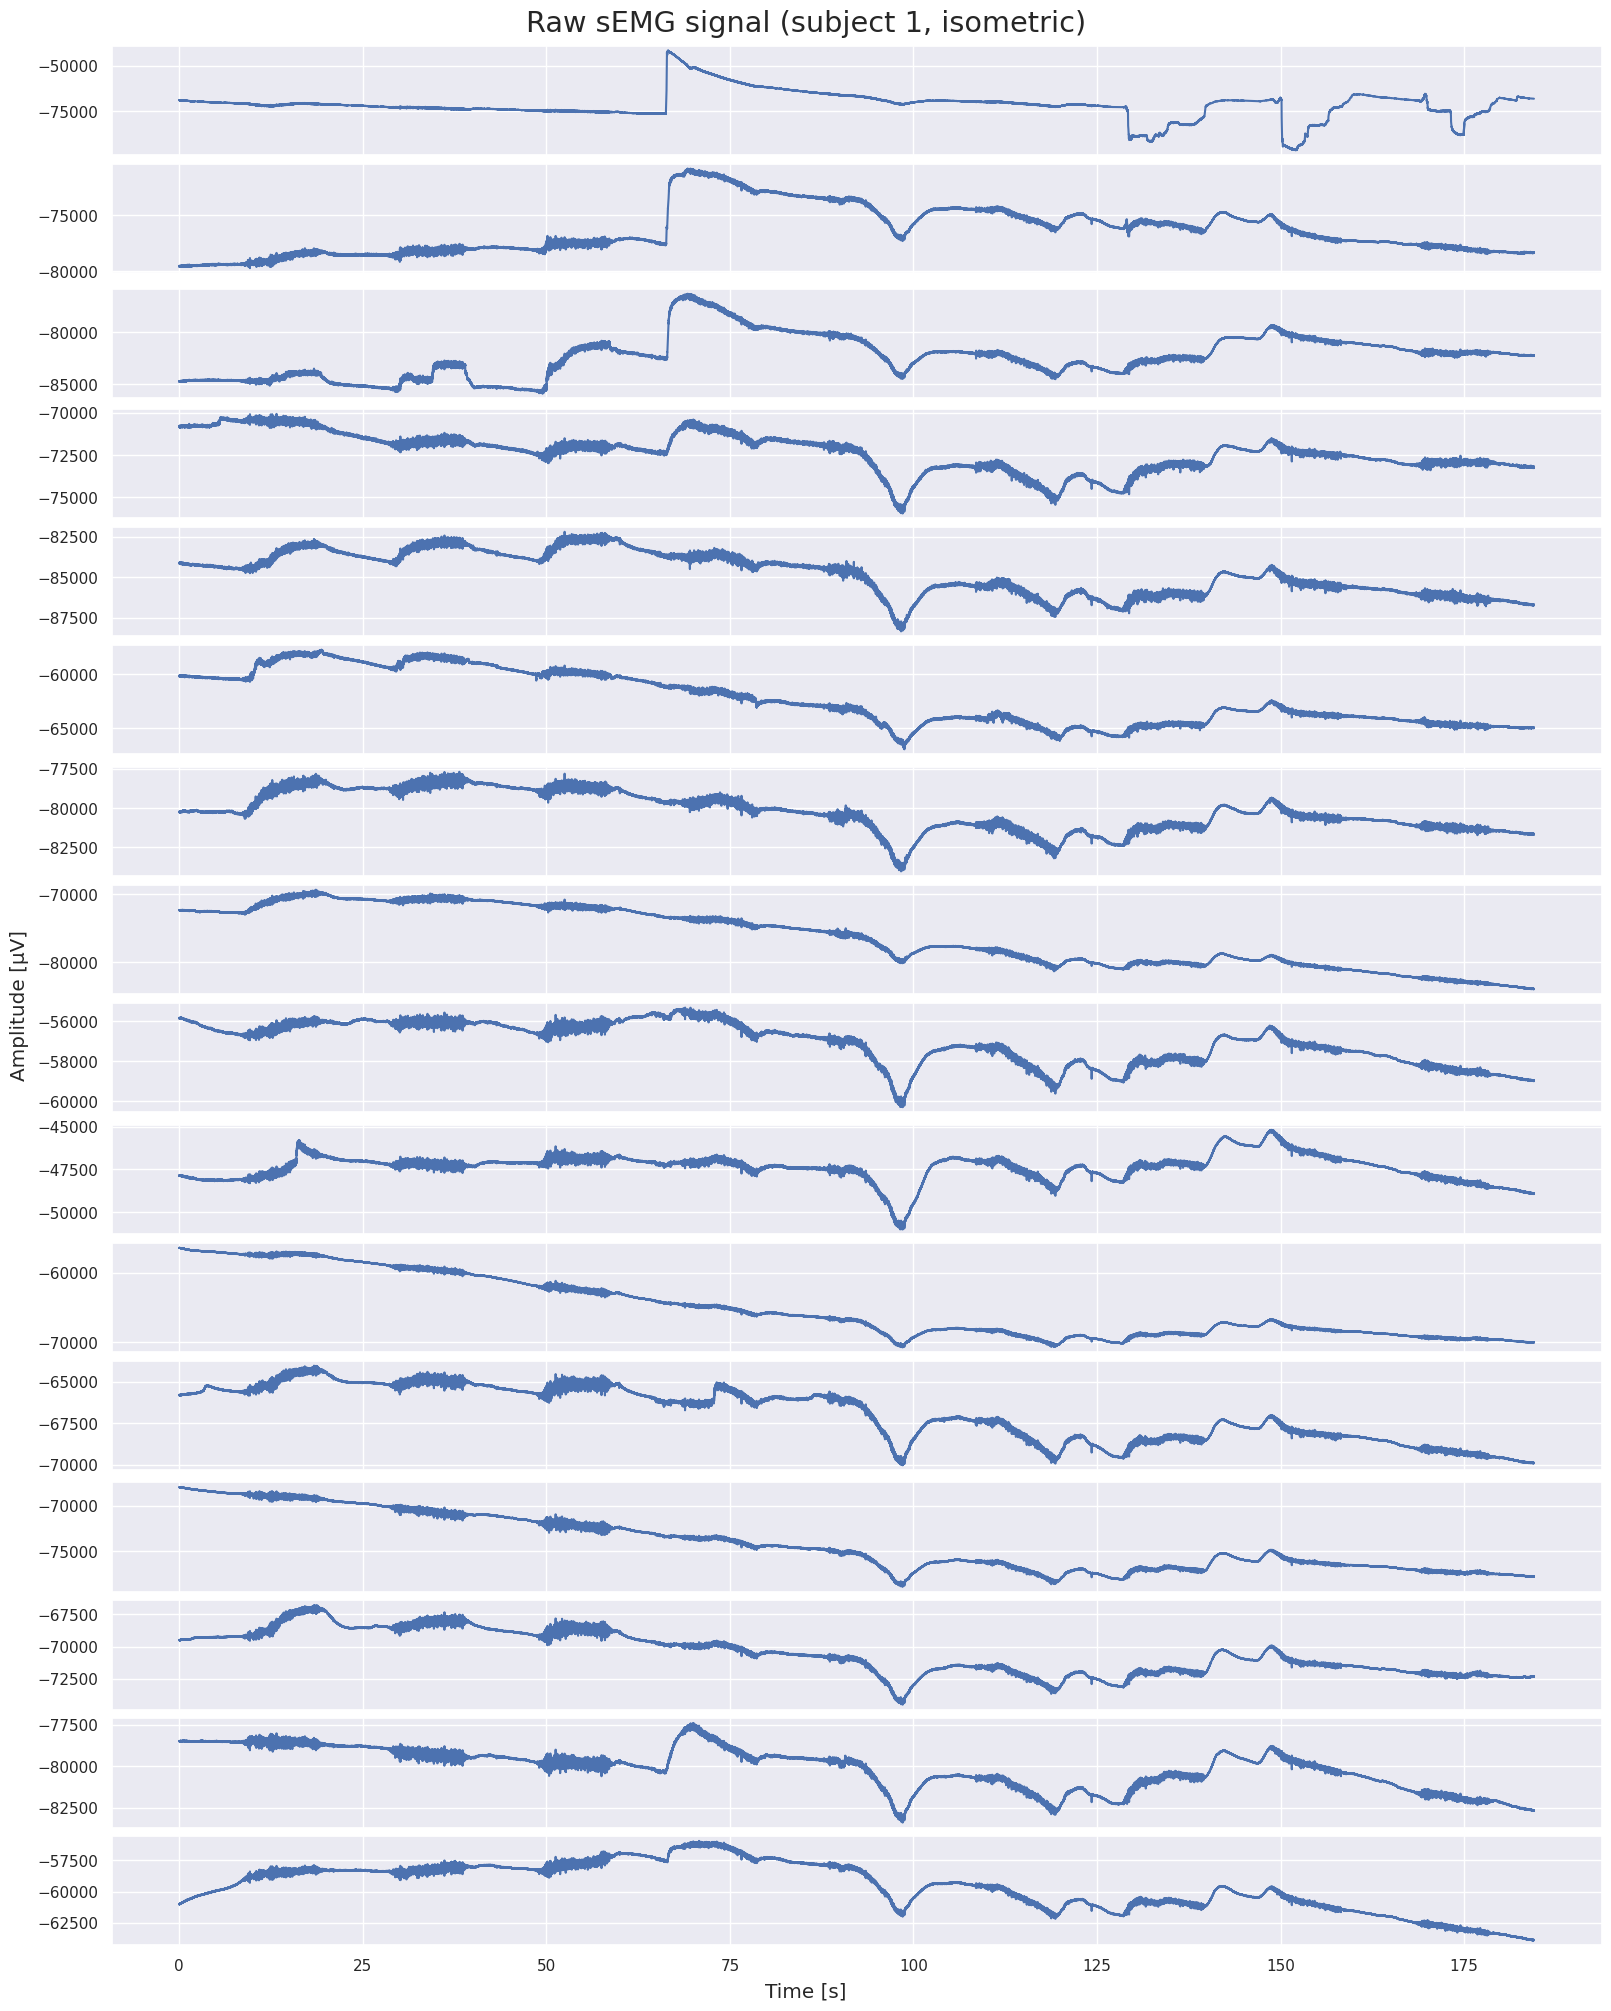

In [3]:
emg = load_data(DATA_DIR, SUBJECT, "isometric")

plotting.plot_signal(
    emg,
    fs=FS,
    title=f"Raw sEMG signal (subject {SUBJECT}, isometric)",
    y_label="Amplitude [\u03BCV]",
    fig_size=(16, 20),
)

Apply a 20Hz high-pass filter.

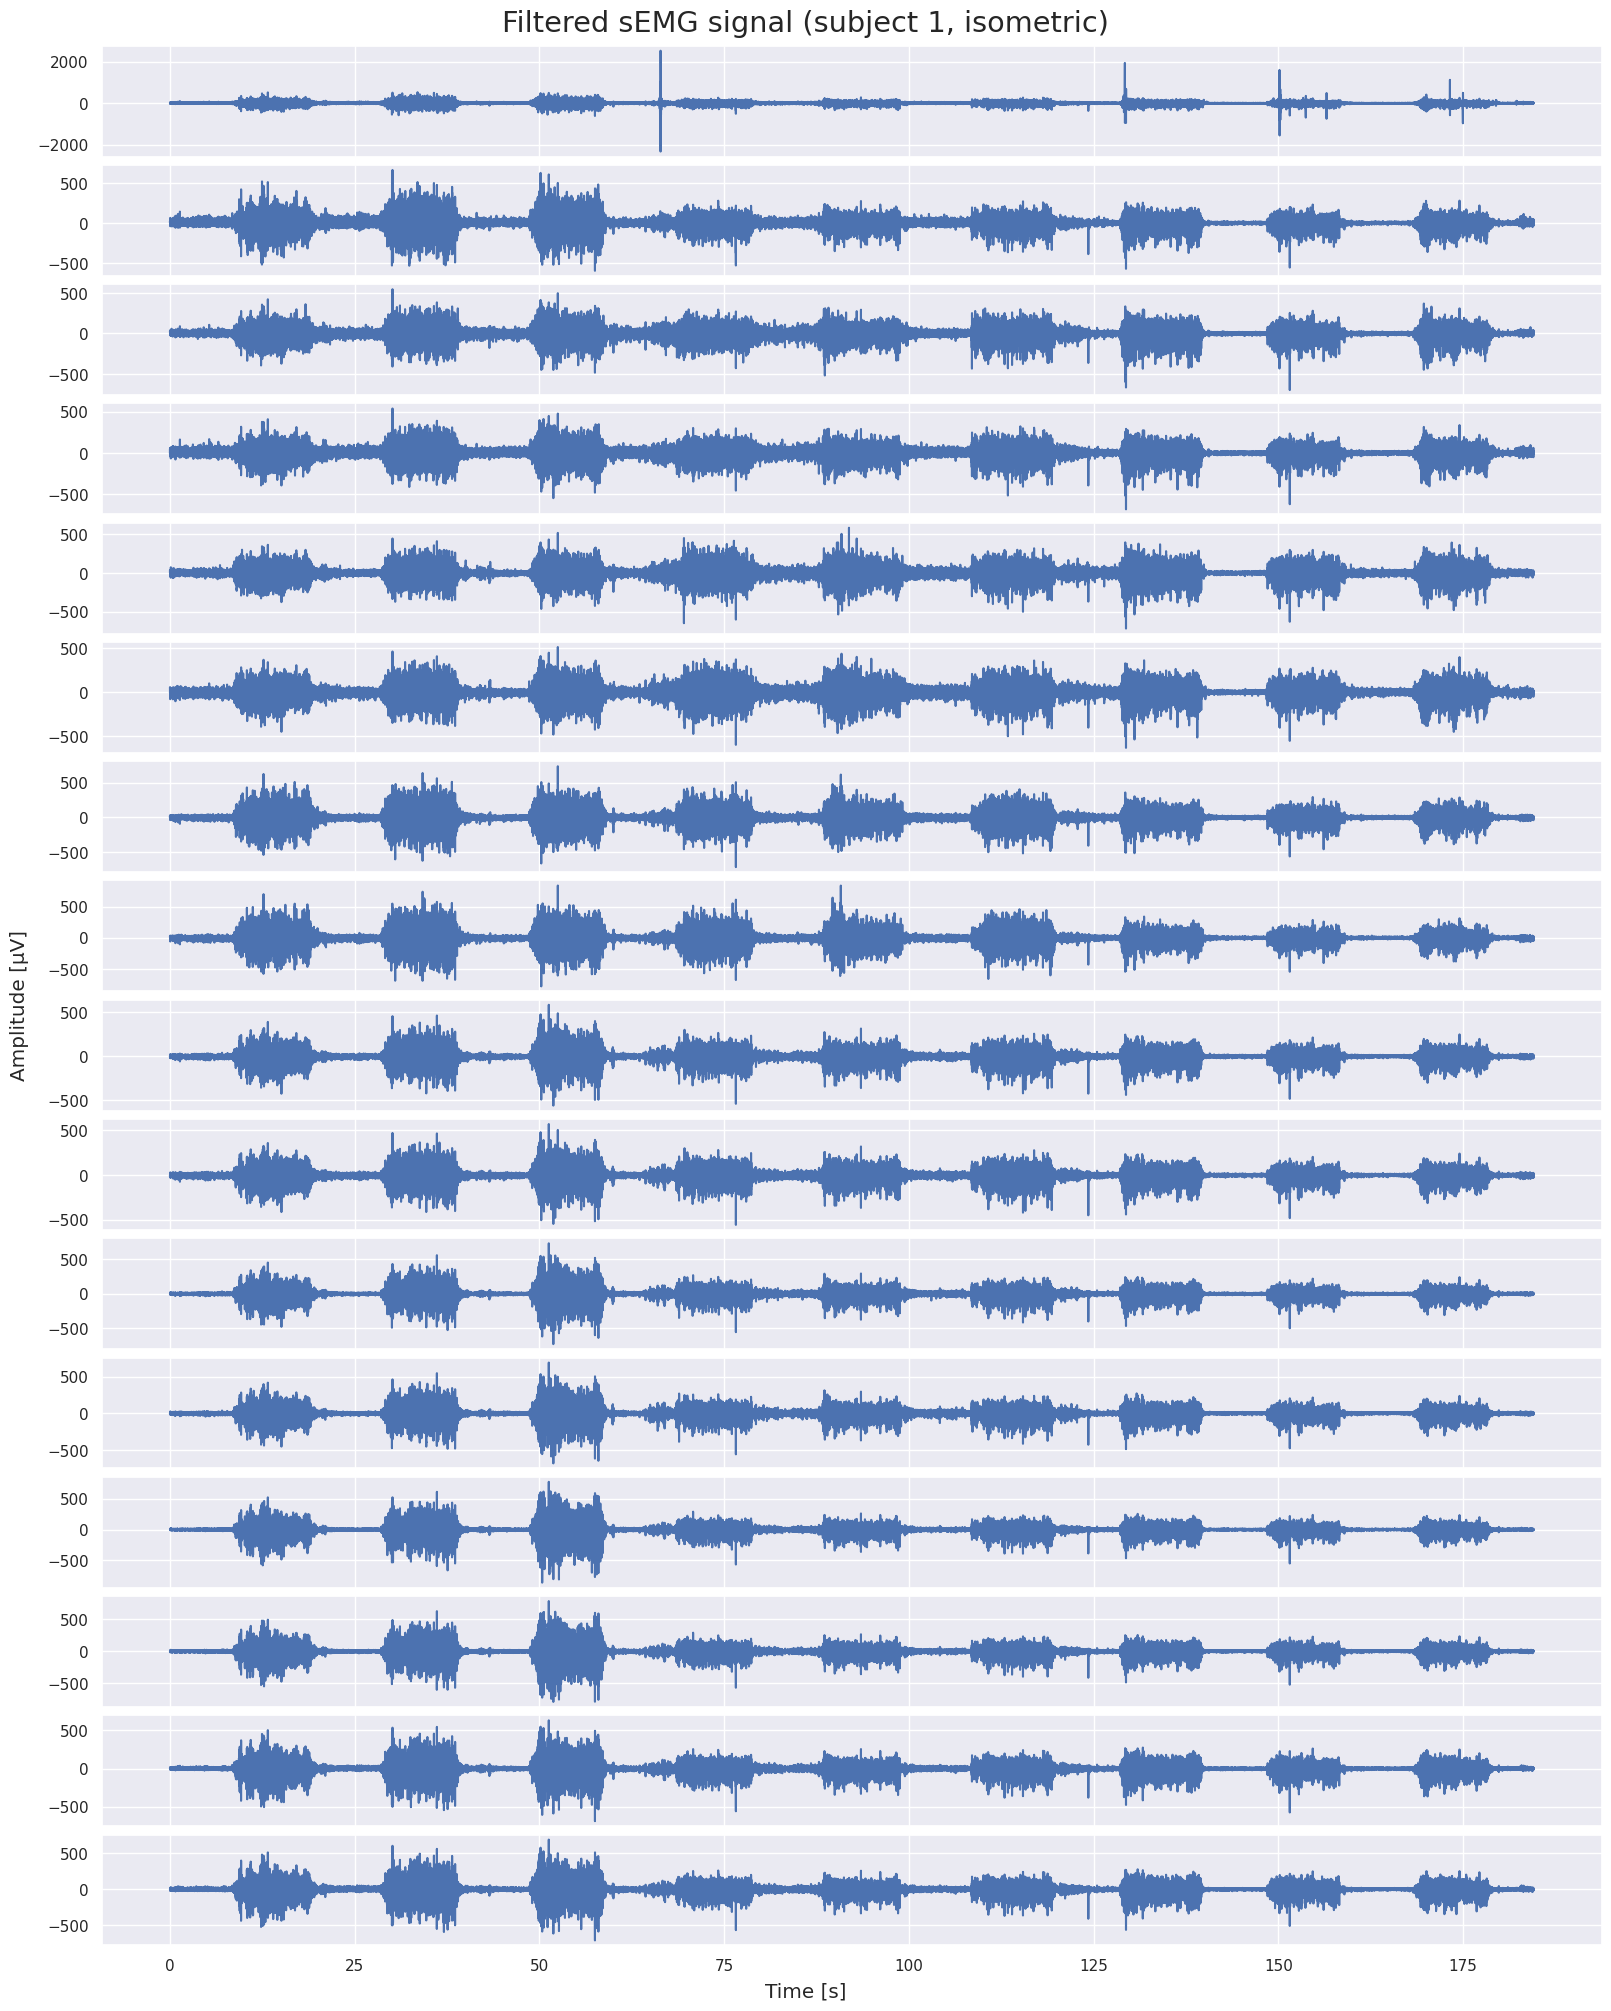

In [4]:
emg = preprocessing.highpass_filter(emg, cut=20, fs=FS, order=2)

plotting.plot_signal(
    emg,
    fs=FS,
    title=f"Filtered sEMG signal (subject {SUBJECT}, isometric)",
    y_label="Amplitude [\u03BCV]",
    fig_size=(16, 20),
)

Compute the RMS and isolate the plateau.

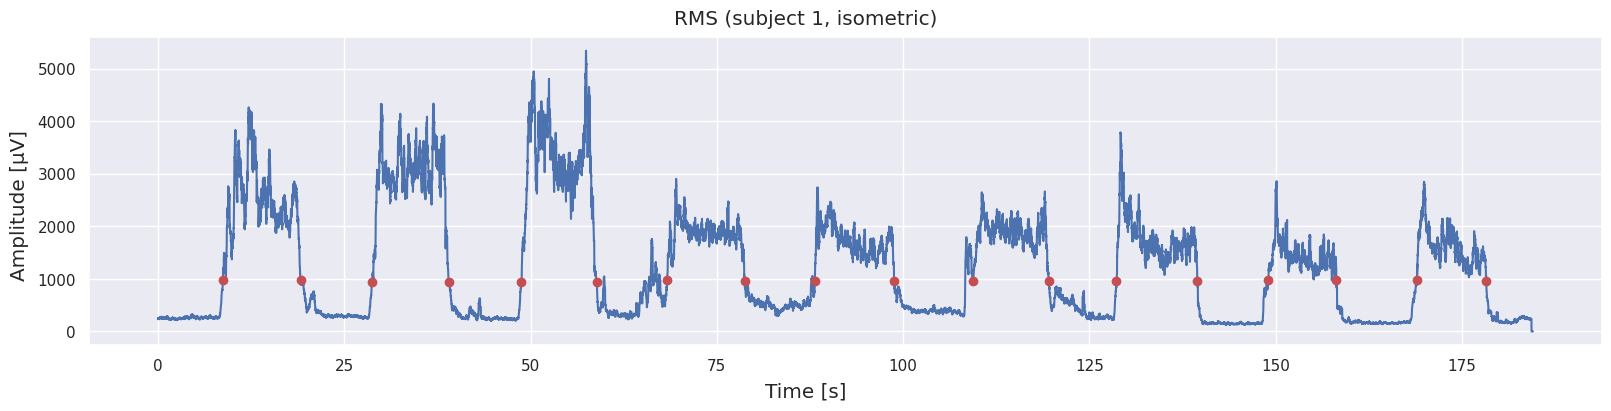

In [5]:
grasp_idx_dict = {
    1: np.asarray([34871, 76607, 114955, 156005, 195128, 235475]),
    2: np.asarray([35808, 79393, 114755, 166244, 194128, 237460]),
}
pinch_idx_dict = {
    1: np.asarray([273304, 314935, 352603, 395086, 437693, 478183]),
    2: np.asarray([274502, 315864, 354587, 397868, 435512, 476417]),
}
hand_open_idx_dict = {
    1: np.asarray([514452, 557909, 596073, 632521, 675792, 712970]),
    2: np.asarray([516325, 554166, 596869, 634747, 677331, 714099]),
}

grasp_idx = grasp_idx_dict[SUBJECT]
pinch_idx = pinch_idx_dict[SUBJECT]
hand_open_idx = hand_open_idx_dict[SUBJECT]

win_len = int(round(0.2 * FS))

emg_rms = np.zeros_like(emg)
for i in range(emg.shape[1] - win_len):
    cur_rms = (emg[:, i : i + win_len] ** 2).sum(axis=1)
    emg_rms[:, i] = np.sqrt(cur_rms)
emg_rms = np.mean(emg_rms, axis=0)

f, ax = plt.subplots(figsize=(16, 4), layout="constrained")
f.suptitle(f"RMS (subject {SUBJECT}, isometric)")
f.supxlabel("Time [s]")
f.supylabel("Amplitude [\u03BCV]")

t = np.arange(emg.shape[1]) / FS
ax.plot(t, emg_rms)
ax.plot(t[grasp_idx], emg_rms[grasp_idx], "ro")
ax.plot(t[pinch_idx], emg_rms[pinch_idx], "ro")
ax.plot(t[hand_open_idx], emg_rms[hand_open_idx], "ro")
plt.show()

Divide in training and test sets.

In [6]:
slice_len = int(round(6 * FS))
pad_len = int(round(2 * FS))

labels_idx = np.concatenate((grasp_idx, pinch_idx, hand_open_idx))
emg_train = np.zeros(shape=(0, 16, slice_len))
emg_test = np.zeros(shape=(0, 16, slice_len))

for i in range(3):
    emg_train = np.concatenate(
        (
            emg_train,
            np.expand_dims(
                emg[
                    :,
                    labels_idx[6 * i]
                    + pad_len : labels_idx[6 * i]
                    + pad_len
                    + slice_len,
                ],
                axis=0,
            ),
        )
    )
    emg_train = np.concatenate(
        (
            emg_train,
            np.expand_dims(
                emg[:, labels_idx[6 * i + 2] : labels_idx[6 * i + 2] + slice_len],
                axis=0,
            ),
        )
    )
    emg_test = np.concatenate(
        (
            emg_test,
            np.expand_dims(
                emg[:, labels_idx[6 * i + 4] : labels_idx[6 * i + 4] + slice_len],
                axis=0,
            ),
        )
    )

emg_train = np.swapaxes(emg_train, 0, 1).reshape(16, -1)
emg_test = np.swapaxes(emg_test, 0, 1).reshape(16, -1)

emg_train.shape, emg_test.shape

((16, 144000), (16, 72000))

Run the decomposition algorithm.

In [7]:
decomp_model = decomposition.ConvBSS(
    fs=FS,
    f_ext_ms=2.0,
    sil_th=0.6,
    fr_th=5.0,
    exclude_long_intervals=True,
    seed=SEED,
    device=device,
)
muapts_train, muapts_bin_train = decomp_model.fit_transform(emg_train)
muapts_test, muapts_bin_test = decomp_model.transform(emg_test)

print(f"Extracted {decomp_model.n_mu} MUs.")

Extracted 8 MUs.


Visualize the extracted motor units.

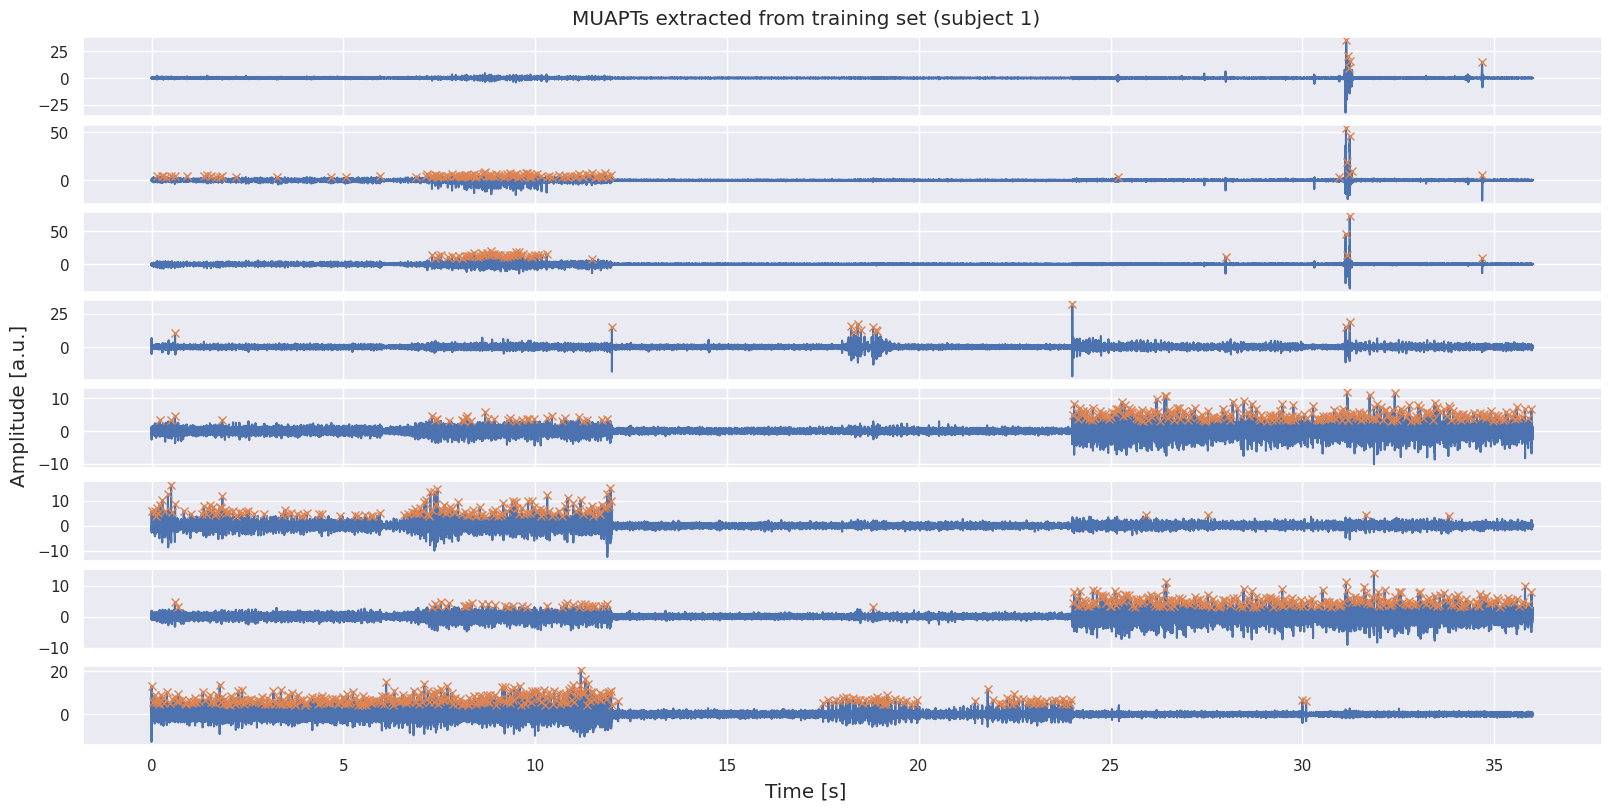

In [8]:
t = np.arange(muapts_train.shape[0]) / FS

f, axes = plt.subplots(
    nrows=decomp_model.n_mu, sharex="all", figsize=(16, 8), layout="constrained"
)
f.suptitle(f"MUAPTs extracted from training set (subject {SUBJECT})")
f.supxlabel("Time [s]")
f.supylabel("Amplitude [a.u.]")

idx = 0
for i in range(decomp_model.n_mu):
    spike_loc = np.flatnonzero(muapts_bin_train[f"MU{i}"])
    axes[idx].plot(t, muapts_train[f"MU{i}"])
    axes[idx].plot(spike_loc / FS, muapts_train[f"MU{i}"].iloc[spike_loc], "x")
    idx += 1

plt.show()

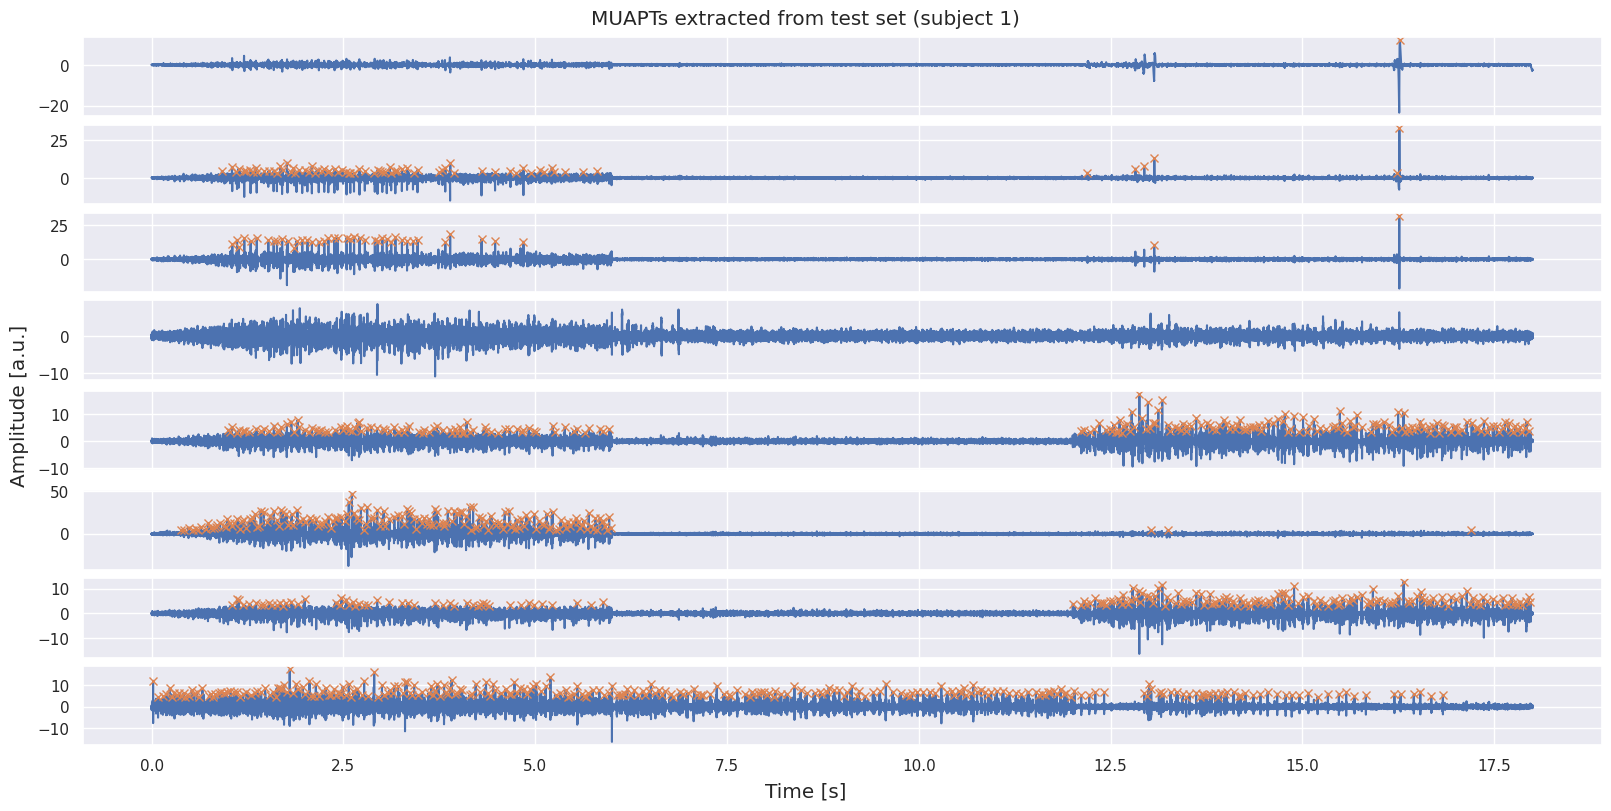

In [9]:
t = np.arange(muapts_test.shape[0]) / FS

f, axes = plt.subplots(
    nrows=decomp_model.n_mu, sharex="all", figsize=(16, 8), layout="constrained"
)
f.suptitle(f"MUAPTs extracted from test set (subject {SUBJECT})")
f.supxlabel("Time [s]")
f.supylabel("Amplitude [a.u.]")

idx = 0
for i in range(decomp_model.n_mu):
    spike_loc = np.flatnonzero(muapts_bin_test[f"MU{i}"])
    axes[idx].plot(t, muapts_test[f"MU{i}"])
    axes[idx].plot(spike_loc / FS, muapts_test[f"MU{i}"].iloc[spike_loc], "x")
    idx += 1

plt.show()

Estimate the MUAP waveforms and visualize them.

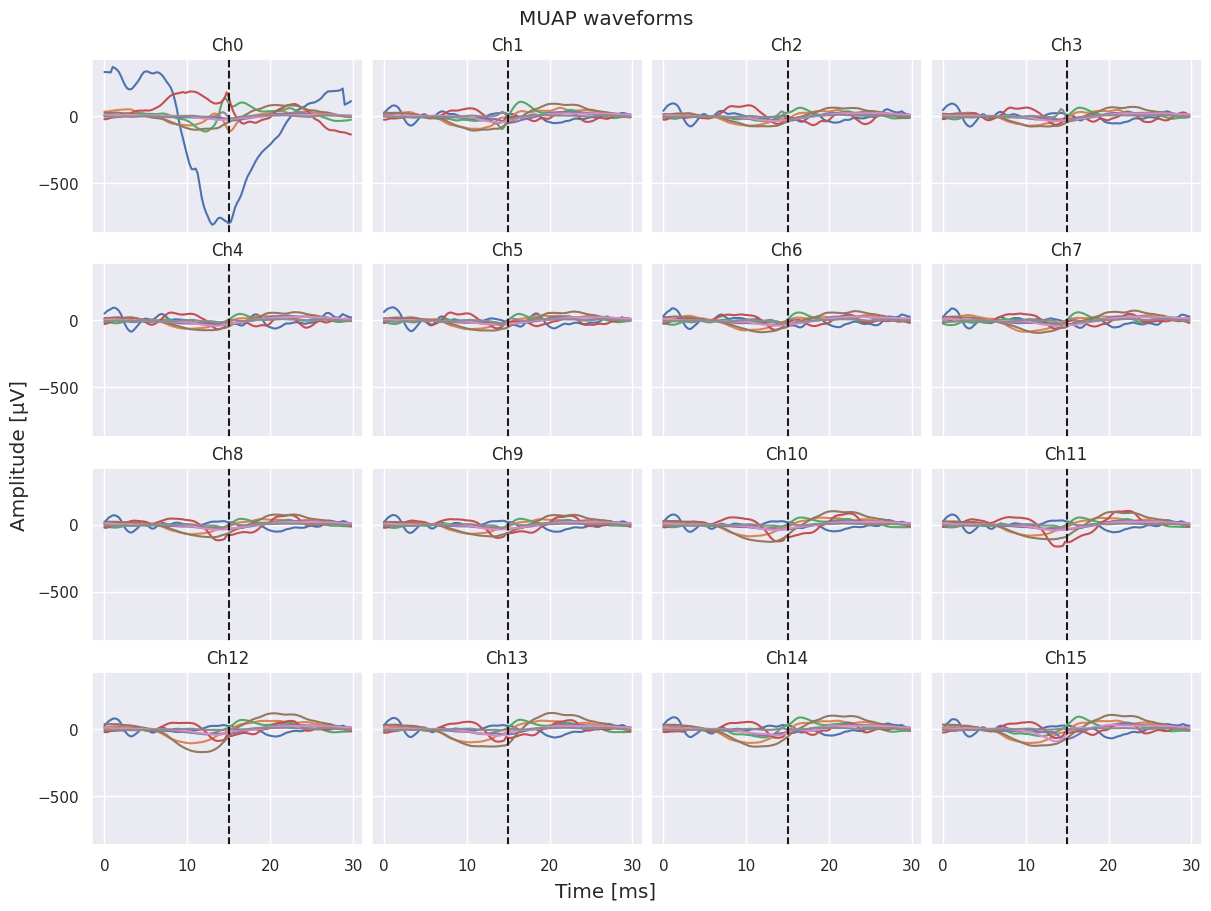

In [10]:
wfs = utils.compute_waveforms(
    emg_train, muapts_bin_train.to_numpy().T, wf_len=int(round(30e-3 * FS))
)

plotting.plot_waveforms(
    wfs=wfs,
    fs=FS,
    n_cols=4,
    y_label="Amplitude [\u03BCV]",
    fig_size=(12, 9),
)

Load the sEMG signal during natural gestures.

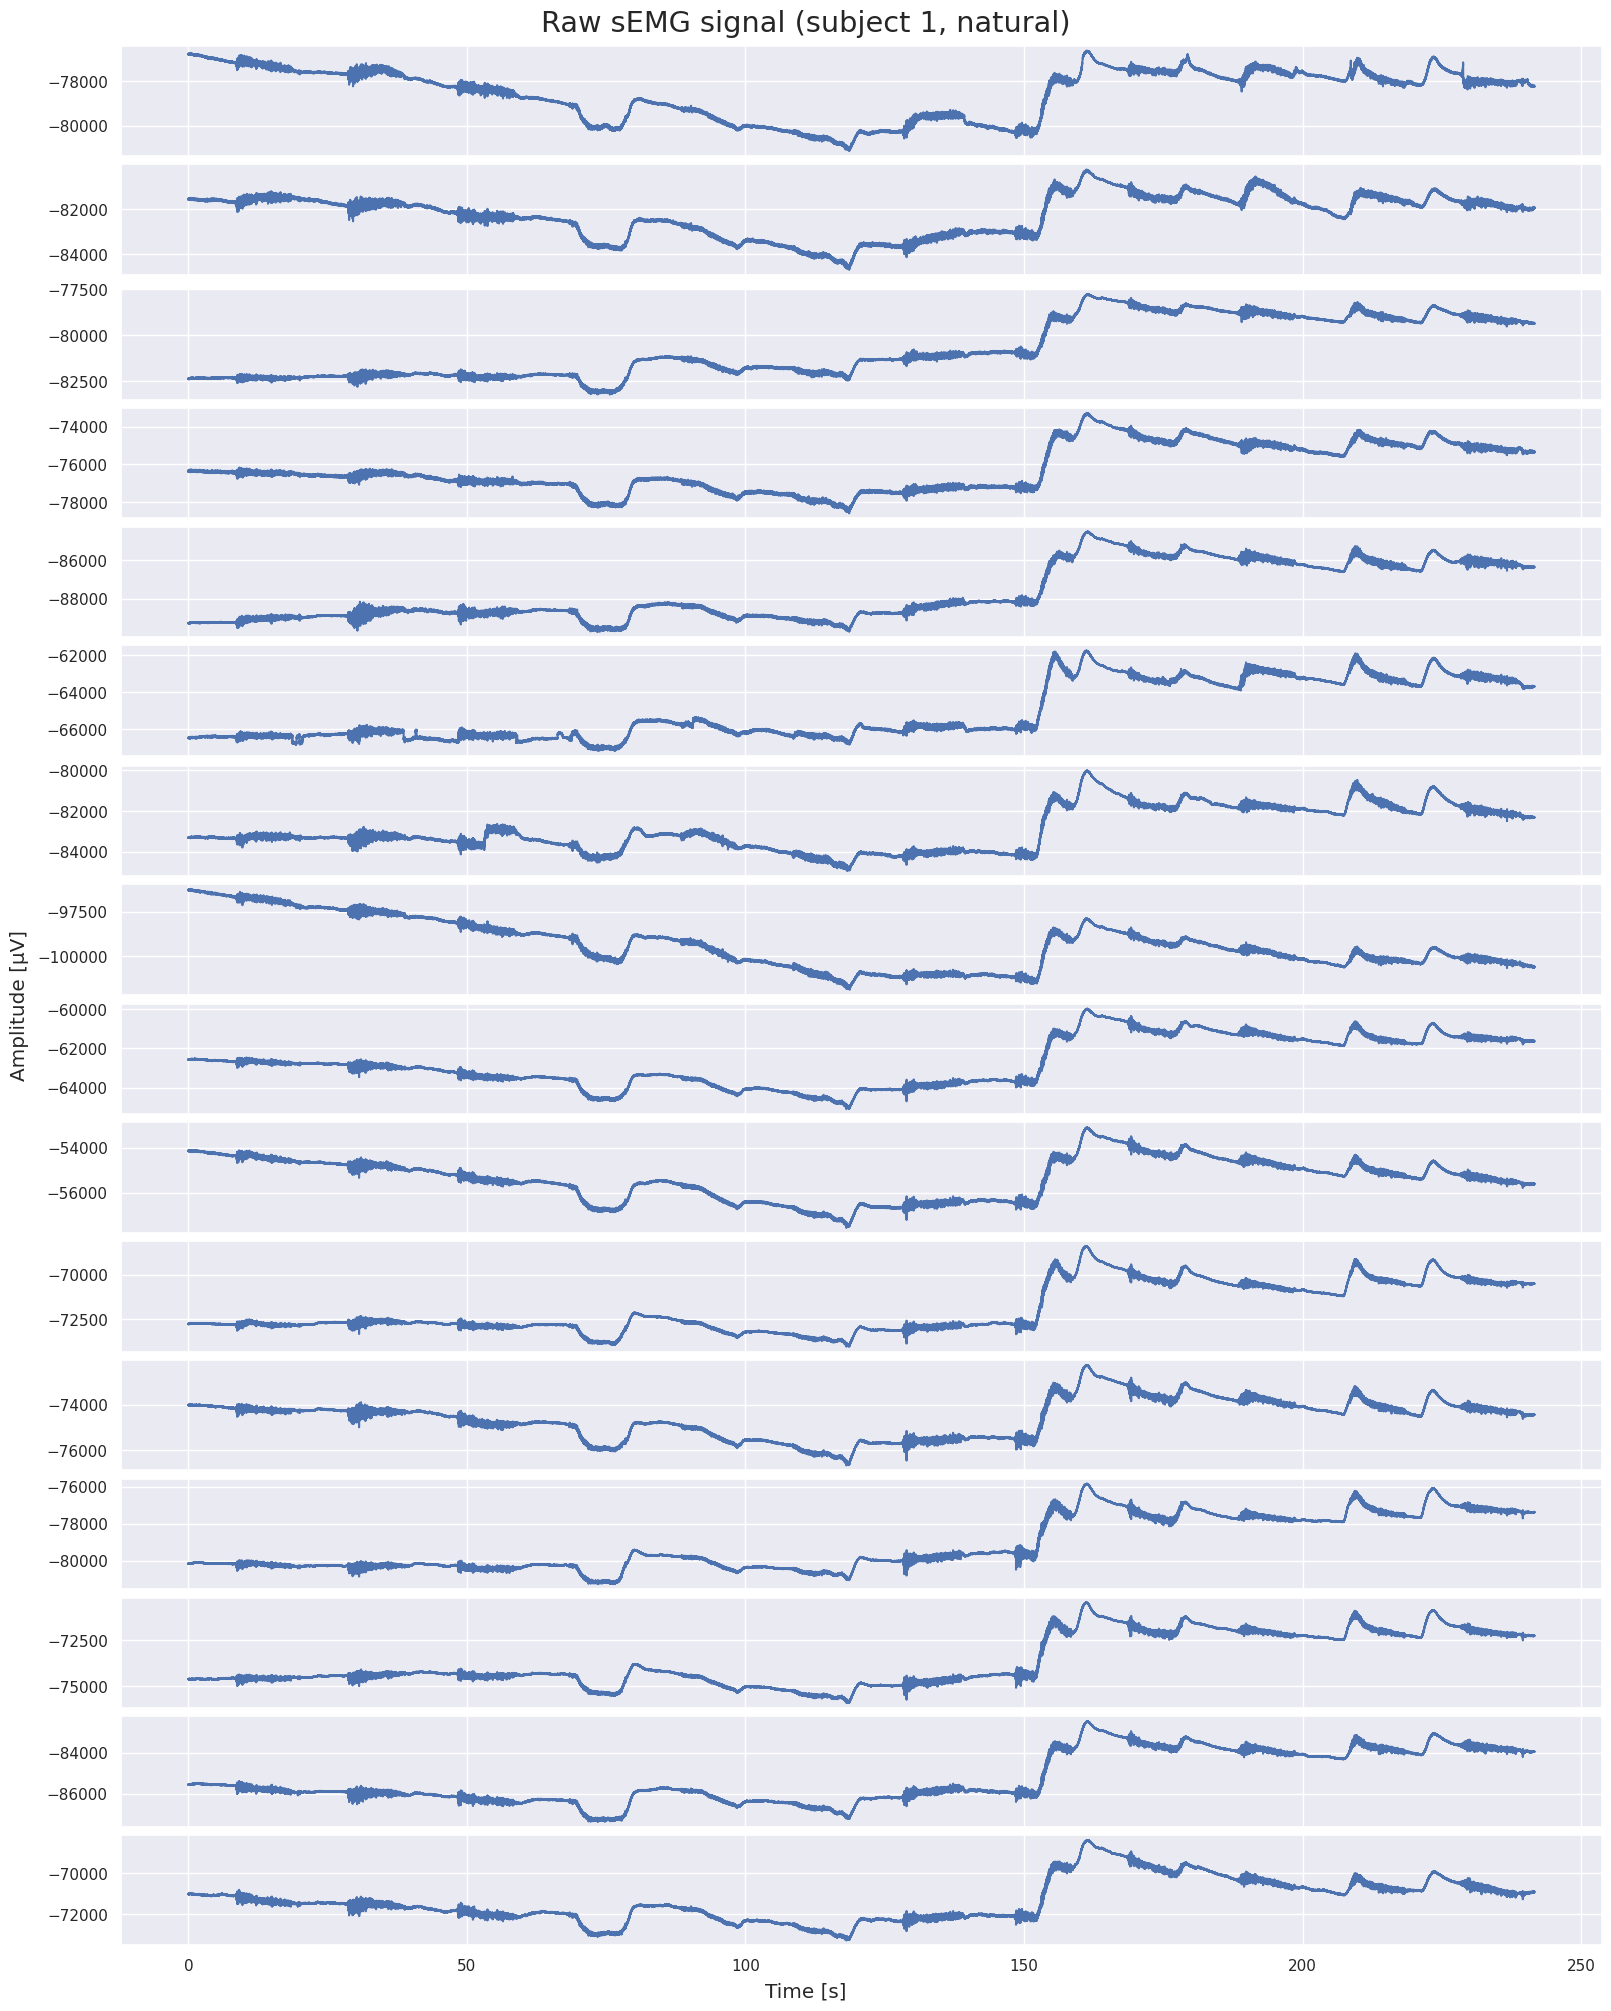

In [11]:
emg_nat = load_data(DATA_DIR, SUBJECT, "natural")

plotting.plot_signal(
    emg_nat,
    fs=FS,
    title=f"Raw sEMG signal (subject {SUBJECT}, natural)",
    y_label="Amplitude [\u03BCV]",
    fig_size=(16, 20),
)

Apply a 20Hz high-pass filter.

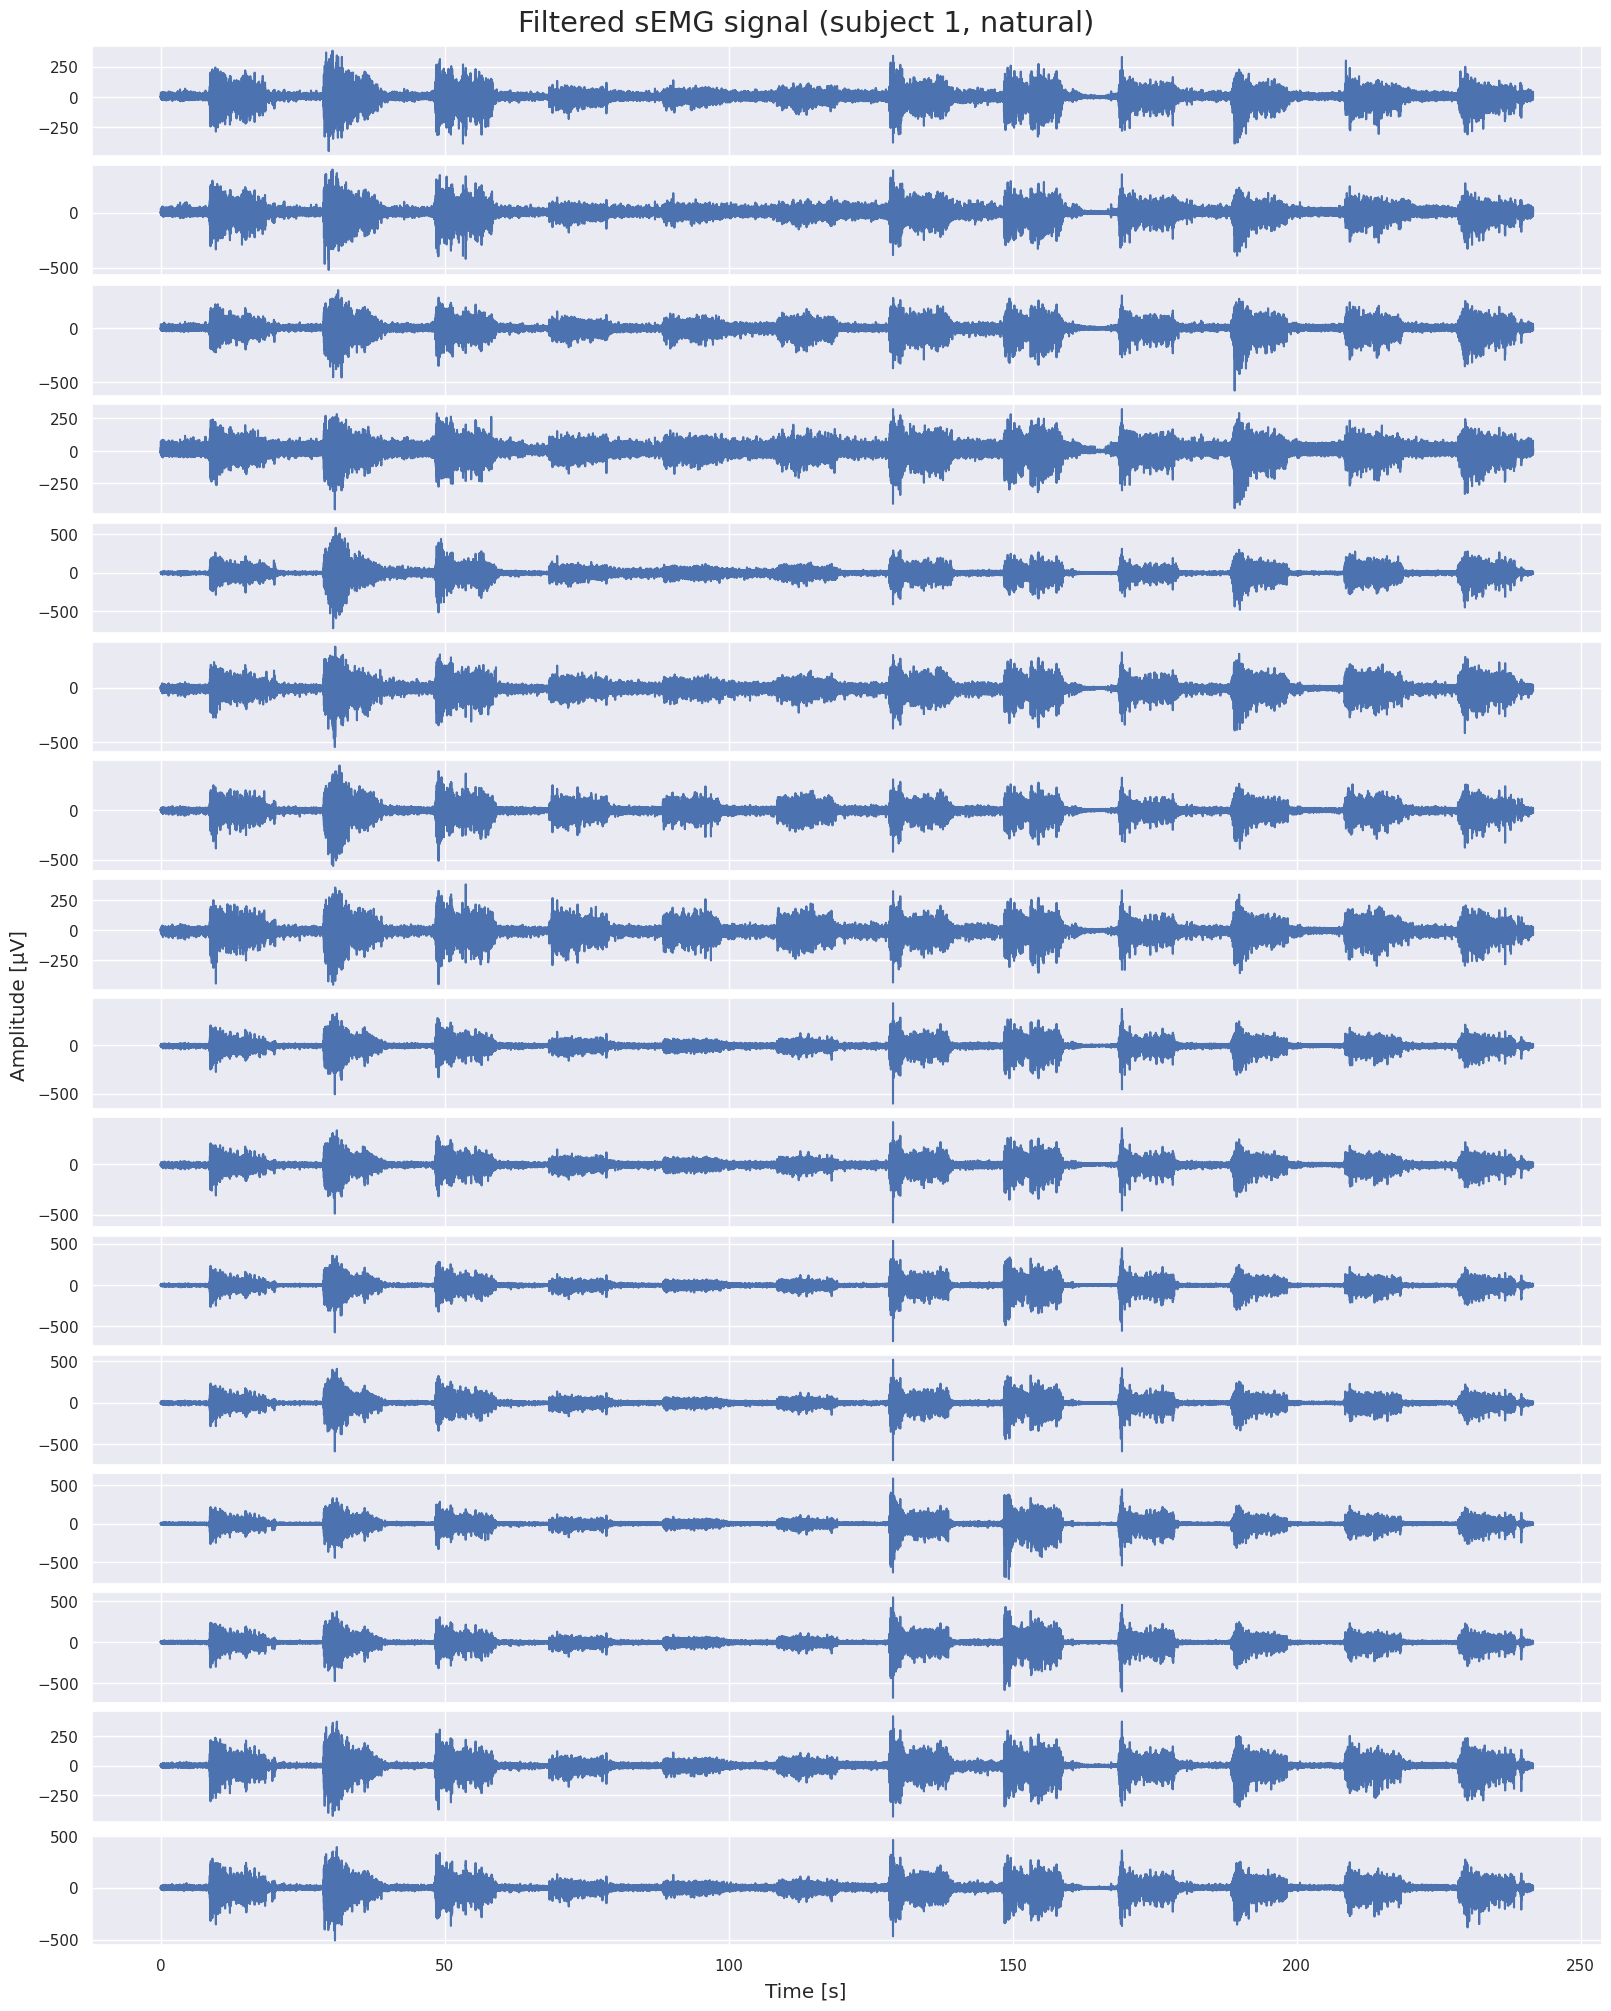

In [12]:
emg_nat = preprocessing.highpass_filter(emg_nat, cut=20, fs=FS, order=2)

plotting.plot_signal(
    emg_nat,
    fs=FS,
    title=f"Filtered sEMG signal (subject {SUBJECT}, natural)",
    y_label="Amplitude [\u03BCV]",
    fig_size=(16, 20),
)

Extend the signal and apply the ORICA algorithm.

In [13]:
emg_ext = preprocessing.extend_signal(emg_nat, f_ext=int(round(2e-3 * FS)))

start = 0
stop = emg_ext.shape[1]
slice_len_ms = 128
slice_len = int(round(slice_len_ms / 1000 * FS))

orica = decomposition.ORICA(
    white_init=decomp_model.white_mtx,
    sep_init=decomp_model.sep_mtx,
    lambda_0=1e-3,
    gamma=0.0,
    device=device,
)

vs = []
ys = []
lambdas = []
w_diffs = []
s_diffs = []
while start + slice_len < stop:
    cur_slice = emg_ext[:, start : start + slice_len]

    v, y, lambda_, w_diff, s_diff = orica.fit_transform(cur_slice)
    vs.append(v)
    ys.append(y)
    lambdas.append(lambda_)
    w_diffs.append(w_diff)
    s_diffs.append(s_diff)

    start += slice_len

vs = np.concatenate(vs, axis=1)
ys = np.concatenate(ys, axis=1)

Visualize ORICA's statistics.

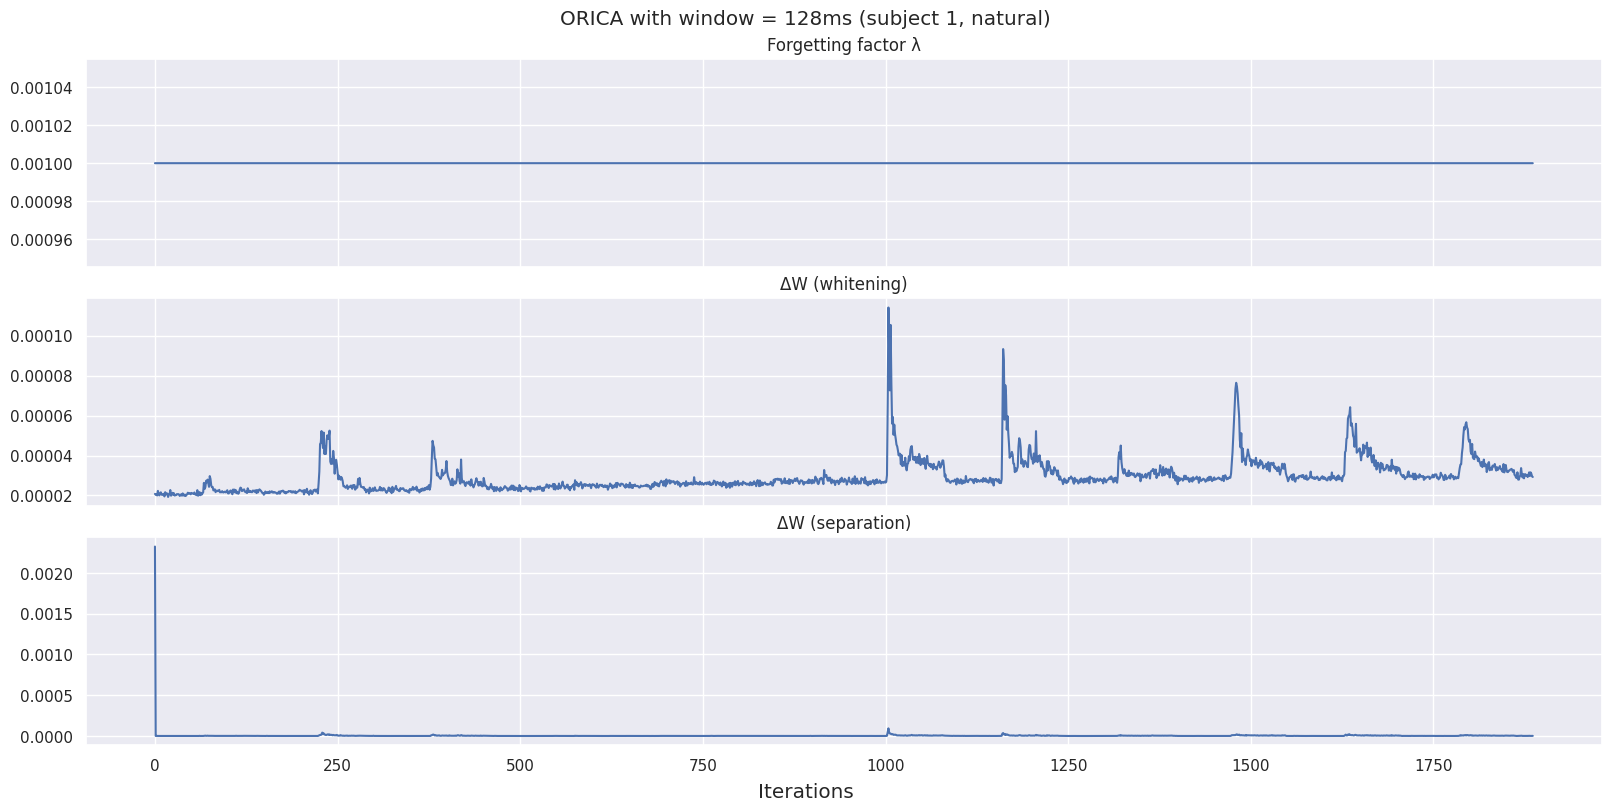

In [14]:
f, axes = plt.subplots(nrows=3, sharex="all", figsize=(16, 8), layout="constrained")
f.suptitle(f"ORICA with window = {slice_len_ms}ms (subject {SUBJECT}, natural)")
f.supxlabel("Iterations")

axes[0].set_title("Forgetting factor \u03BB")
axes[0].plot(lambdas)
axes[1].set_title("\u0394W (whitening)")
axes[1].plot(w_diffs)
axes[2].set_title("\u0394W (separation)")
axes[2].plot(s_diffs)

plt.show()

Visualize the extracted motor units.

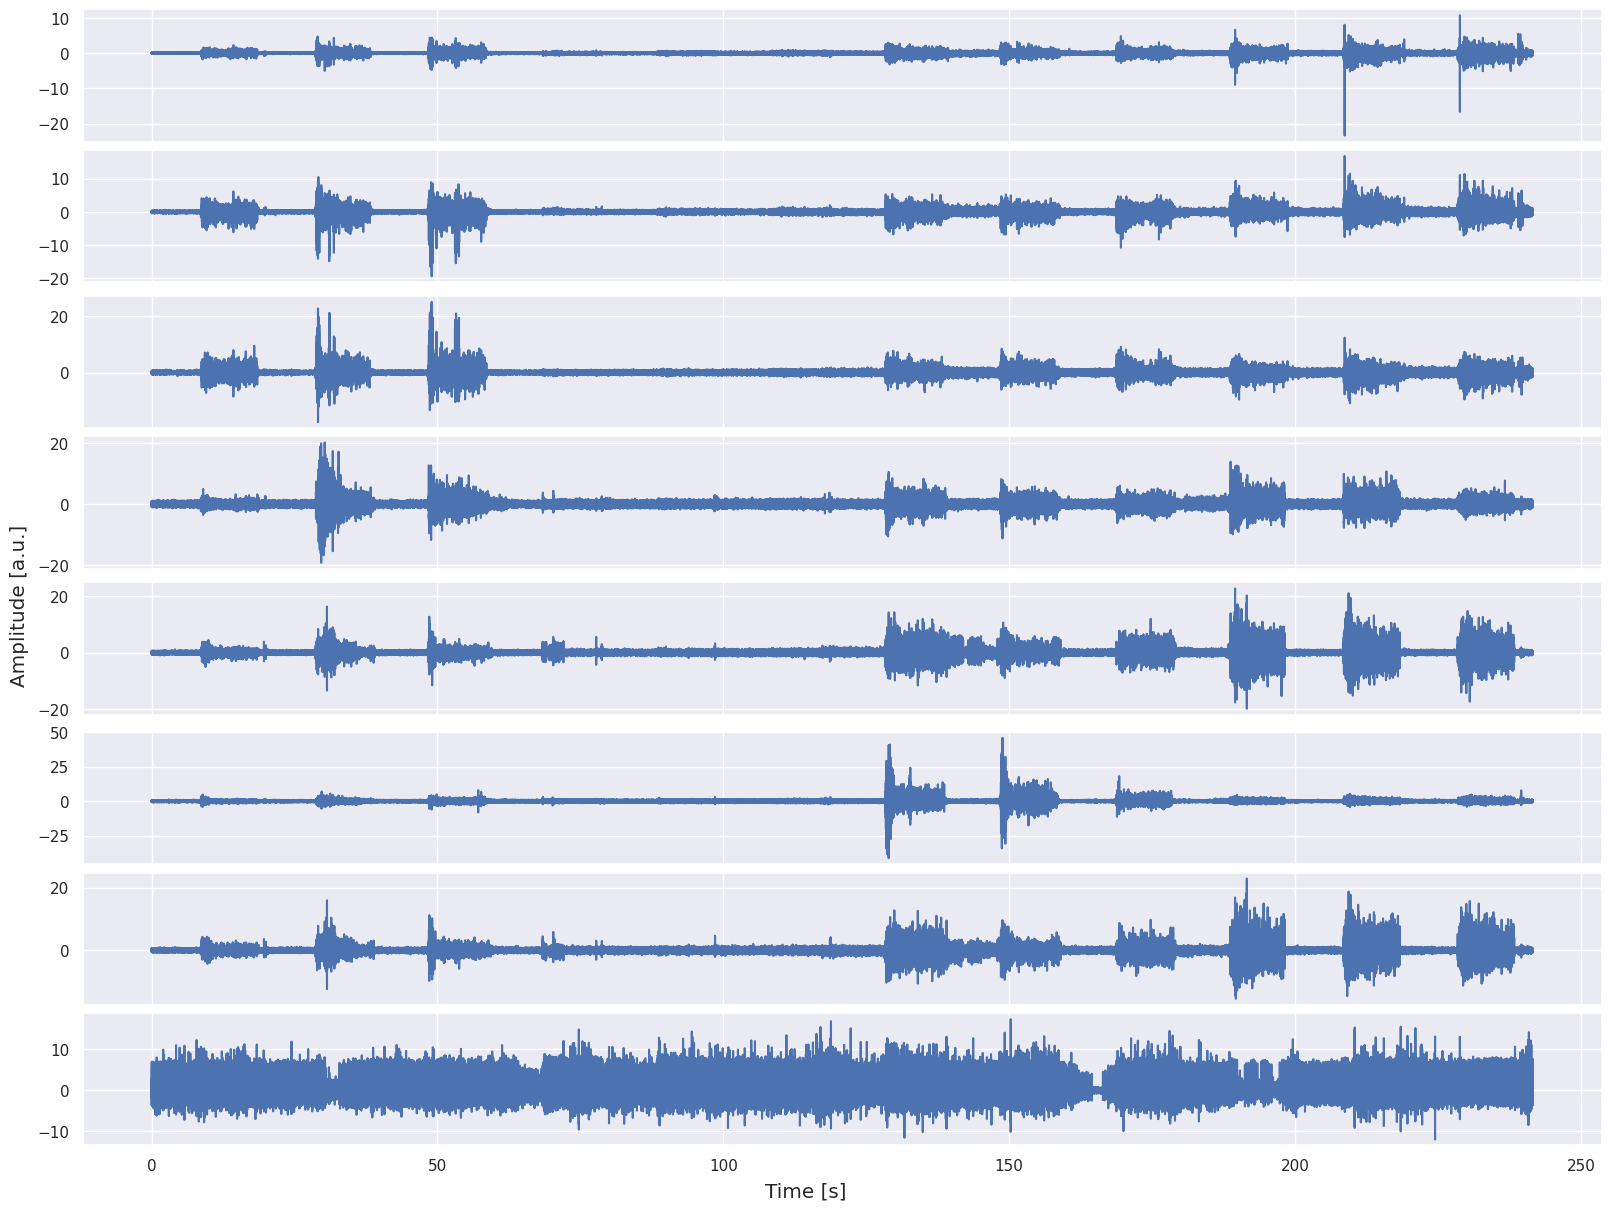

In [15]:
plotting.plot_signal(
    ys,
    fs=FS,
    y_label="Amplitude [a.u.]",
    fig_size=(16, 12),
)

Detect spikes and visualize them.

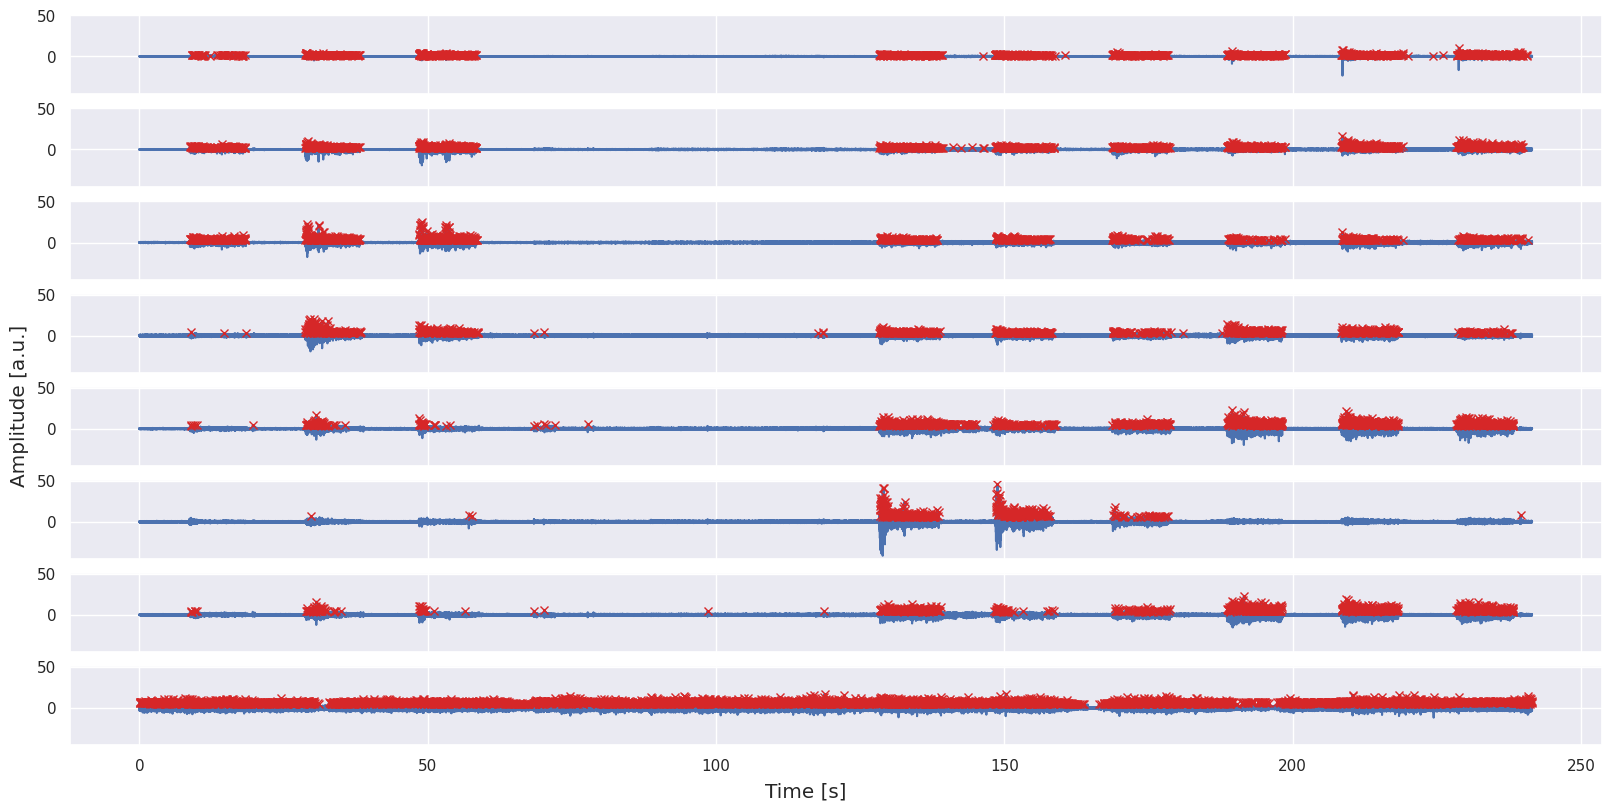

In [16]:
ics_bin = np.zeros(shape=ys.shape, dtype=np.uint8)
n_mu = decomp_model.n_mu
for i in range(n_mu):
    spike_loc_i = utils.detect_spikes(
        ys[i],
        ref_period=int(round(20e-3 * FS)),
        seed=SEED,
    )[0]
    ics_bin[i, spike_loc_i] = 1

# Pack results in a DataFrame
muapts = pd.DataFrame(
    data=ys.T,
    index=[i / FS for i in range(ys.shape[1])],
    columns=[f"MU{i}" for i in range(n_mu)],
)
muapts_bin = pd.DataFrame(
    data=ics_bin.T,
    index=[i / FS for i in range(ys.shape[1])],
    columns=[f"MU{i}" for i in range(n_mu)],
)

t = np.arange(muapts.shape[0]) / FS
n_mu = muapts.shape[1]

f, axes = plt.subplots(nrows=n_mu, sharex="all", sharey="all", figsize=(16, 8), layout="constrained")
f.supxlabel("Time [s]")
f.supylabel("Amplitude [a.u.]")

idx = 0
for i in range(n_mu):
    spike_loc = np.flatnonzero(muapts_bin[f"MU{i}"])
    axes[idx].plot(t, muapts[f"MU{i}"])
    axes[idx].plot(spike_loc / FS, muapts[f"MU{i}"].iloc[spike_loc], "x", color="tab:red")
    idx += 1

plt.show()

Compute RMS and label the gestures.

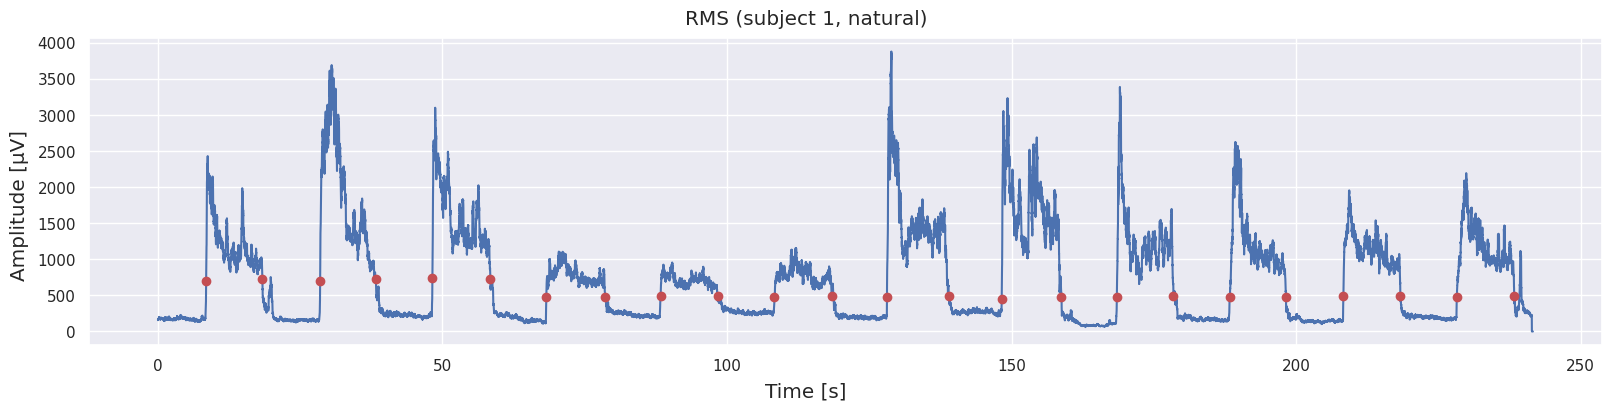

In [17]:
fist_idx_dict = {
    1: np.asarray([33888, 73466, 114074, 153148, 192929, 233617]),
    2: np.asarray([33669, 74602, 113643, 155435, 194086, 235615]),
}
pinch_idx_dict = {
    1: np.asarray([272970, 314456, 353334, 393314, 433358, 473622]),
    2: np.asarray([274191, 313376, 355053, 393637, 434430, 473860]),
}
index_idx_dict = {
    1: np.asarray([512417, 556102, 593036, 635067, 673961, 713722]),
    2: np.asarray([514027, 557363, 593265, 635622, 673154, 715177]),
}
hand_open_idx_dict = {
    1: np.asarray([753369, 792822, 833186, 873207, 912927, 953236]),
    2: np.asarray([754058, 794535, 833156, 886355, 913715, 954082]),
}

fist_idx = fist_idx_dict[SUBJECT]
pinch_idx = pinch_idx_dict[SUBJECT]
index_idx = index_idx_dict[SUBJECT]
hand_open_idx = hand_open_idx_dict[SUBJECT]

win_len = int(round(0.2 * FS))

emg_rms = np.zeros_like(emg_nat)
for i in range(emg_nat.shape[1] - win_len):
    cur_rms = (emg_nat[:, i : i + win_len]**2).sum(axis=1)
    emg_rms[:, i] = np.sqrt(cur_rms)
emg_rms = np.mean(emg_rms, axis=0)

f, ax = plt.subplots(figsize=(16, 4), layout="constrained")
f.suptitle(f"RMS (subject {SUBJECT}, natural)")
f.supxlabel("Time [s]")
f.supylabel("Amplitude [\u03BCV]")

t = np.arange(emg_nat.shape[1]) / FS
ax.plot(t, emg_rms)
ax.plot(t[fist_idx], emg_rms[fist_idx], "ro")
ax.plot(t[pinch_idx], emg_rms[pinch_idx], "ro")
ax.plot(t[index_idx], emg_rms[index_idx], "ro")
ax.plot(t[hand_open_idx], emg_rms[hand_open_idx], "ro")
plt.show()

Divide in training and test sets.

In [18]:
slice_len_s = 0.2  # = 200 ms
step_len_s = 0.01  # = 10 ms
slice_len = int(round(slice_len_s * FS))
step_len = int(round(step_len_s * FS))
pad_len = int(round(2 * FS))

n_mu = decomp_model.n_mu

# Output matrices
X_train = np.zeros(shape=(0, n_mu))
y_train = np.zeros(shape=(0,), dtype=np.uint8)
X_test = np.zeros(shape=(0, n_mu))
y_test = np.zeros(shape=(0,), dtype=np.uint8)

for i in range(0, 4, 2):
    for l_, idx in enumerate((fist_idx, pinch_idx, index_idx, hand_open_idx)):
        cur_slice = muapts_bin.to_numpy().T[:, idx[i] : idx[i + 1]]
        start = pad_len
        stop = cur_slice.shape[1] - pad_len
        while start + slice_len < stop:
            X_train = np.concatenate(
                (
                    X_train,
                    cur_slice[:, start : start + slice_len].sum(axis=1).reshape(1, -1)
                )
            )
            y_train = np.concatenate((y_train, (l_,)))

            start += slice_len
for i in range(4, 6, 2):
    for l_, idx in enumerate((fist_idx, pinch_idx, index_idx, hand_open_idx)):
        cur_slice = muapts_bin.to_numpy().T[:, idx[i] : idx[i + 1]]
        start = pad_len
        stop = cur_slice.shape[1] - pad_len
        while start + slice_len < stop:
            X_test = np.concatenate(
                (
                    X_test,
                    cur_slice[:, start : start + slice_len].sum(axis=1).reshape(1, -1)
                )
            )
            y_test = np.concatenate((y_test, (l_,)))

            start += slice_len

print("Shape of training data:", X_train.shape, y_train.shape)
print("Shape of test data:", X_test.shape, y_test.shape)

Shape of training data: (242, 8) (242,)
Shape of test data: (119, 8) (119,)


Visualize spikes as a heatmap.

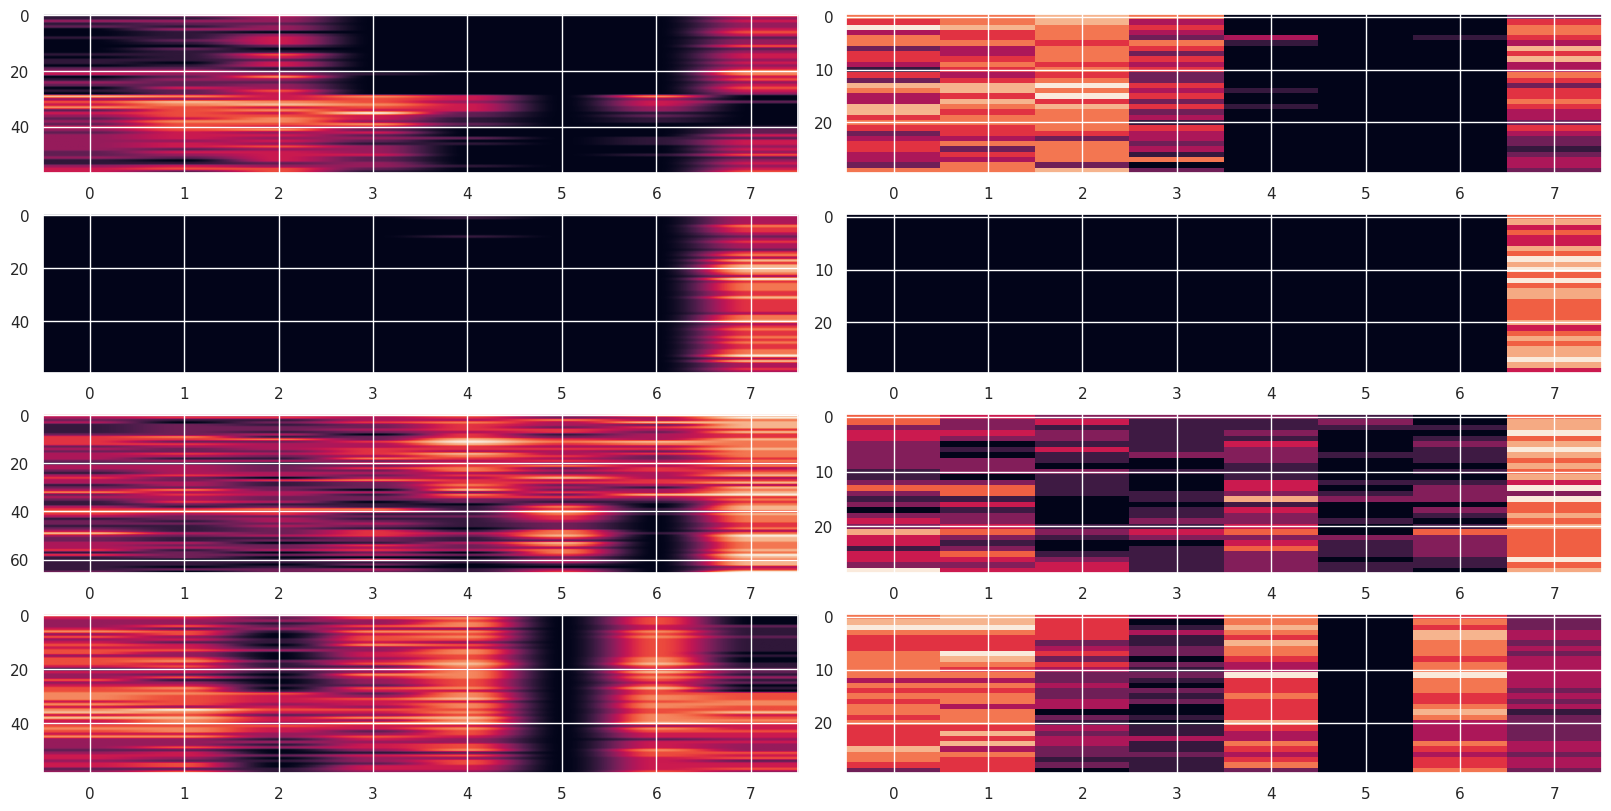

In [19]:
_, axes = plt.subplots(ncols=2, nrows=4, figsize=(16, 8), layout="constrained")

axes[0, 0].imshow(X_train[y_train == 0], aspect="auto")
axes[0, 1].imshow(X_test[y_test == 0], aspect="auto")
axes[1, 0].imshow(X_train[y_train == 1], aspect="auto")
axes[1, 1].imshow(X_test[y_test == 1], aspect="auto")
axes[2, 0].imshow(X_train[y_train == 2], aspect="auto")
axes[2, 1].imshow(X_test[y_test == 2], aspect="auto")
axes[3, 0].imshow(X_train[y_train == 3], aspect="auto")
axes[3, 1].imshow(X_test[y_test == 3], aspect="auto")

plt.show()

Visualize the distribution of labels.

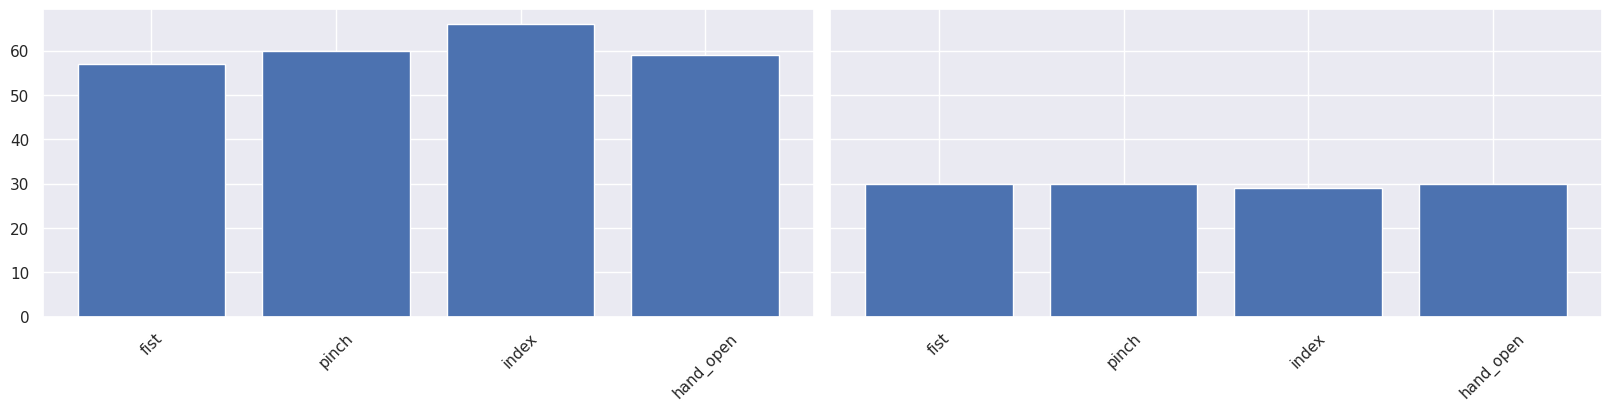

In [20]:
label_dict = {
    "fist": 0,
    "pinch": 1,
    "index": 2,
    "hand_open": 3,
}

plotting.data_distribution((y_train, y_test), label_dict, fig_size=(16, 4))

Train SVM and visualize the confusion matrix.

In [21]:
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

clf = SVC(kernel="rbf", C=1000, gamma=1e-2)
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print("=" * 20, "Training set", "=" * 20)
print(classification_report(y_train, y_pred_train, target_names=list(label_dict.keys()), digits=5))
print("=" * 22, "Test set", "=" * 22)
print(classification_report(y_test, y_pred_test, target_names=list(label_dict.keys()), digits=5))

==================== Training set ====================
              precision    recall  f1-score   support

        fist    1.00000   1.00000   1.00000        57
       pinch    1.00000   1.00000   1.00000        60
       index    1.00000   1.00000   1.00000        66
   hand_open    1.00000   1.00000   1.00000        59

    accuracy                        1.00000       242
   macro avg    1.00000   1.00000   1.00000       242
weighted avg    1.00000   1.00000   1.00000       242

====================== Test set ======================
              precision    recall  f1-score   support

        fist    0.90909   1.00000   0.95238        30
       pinch    1.00000   1.00000   1.00000        30
       index    1.00000   0.82759   0.90566        29
   hand_open    0.93750   1.00000   0.96774        30

    accuracy                        0.95798       119
   macro avg    0.96165   0.95690   0.95645       119
weighted avg    0.96133   0.95798   0.95687       119


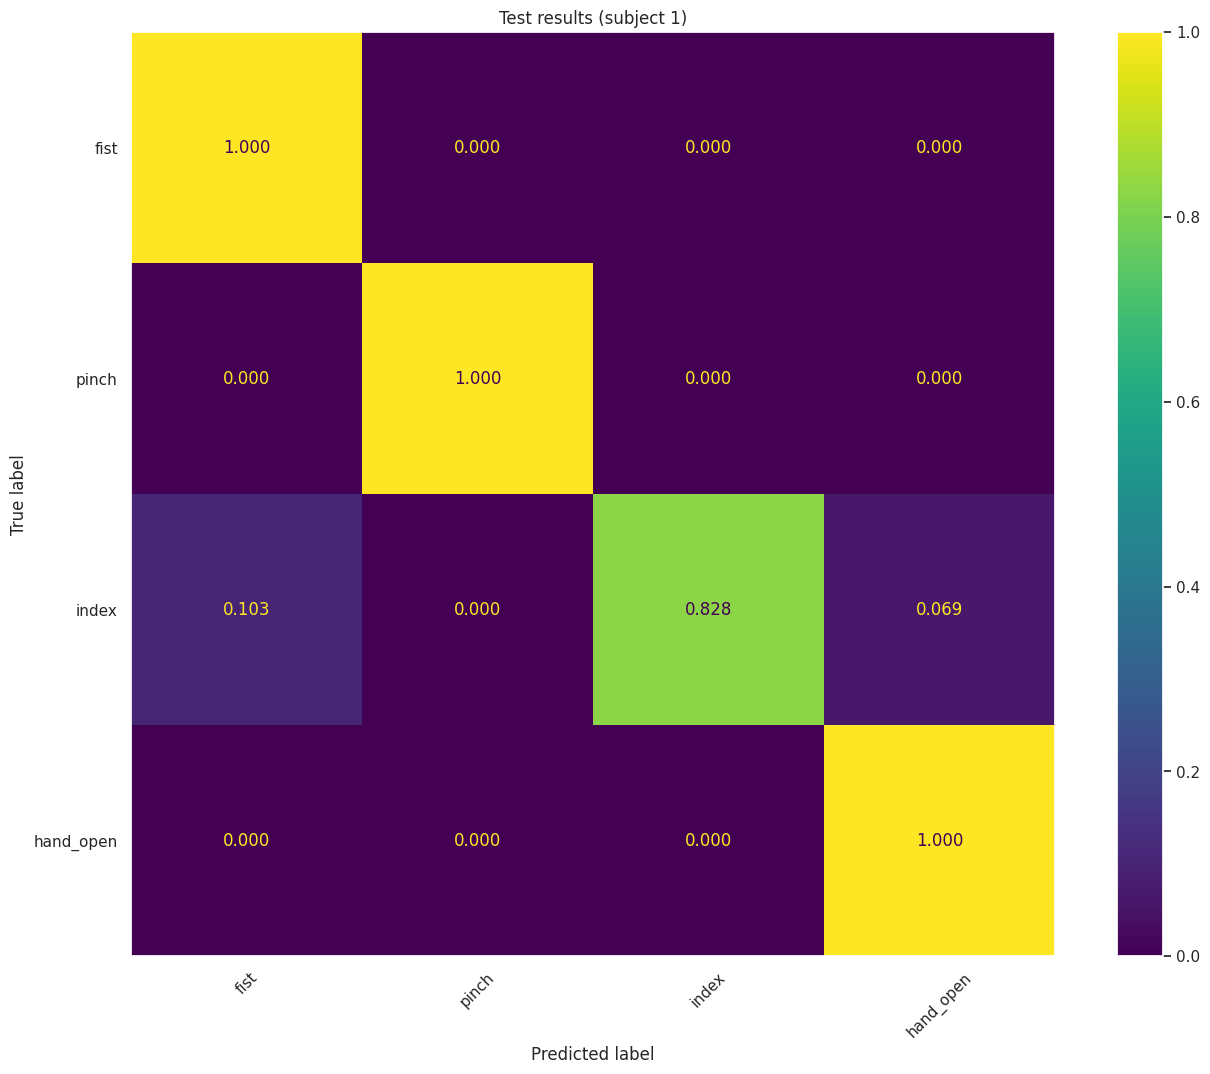

In [22]:
_, ax = plt.subplots(figsize=(16, 12))
ax.grid(False)
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_test,
    normalize="true",
    display_labels=list(label_dict.keys()),
    xticks_rotation=45,
    values_format=".3f",
    ax=ax,
)
disp.ax_.set_title(f"Test results (subject {SUBJECT})")
plt.show()